In [196]:
!pip install --quiet langchain-community langchain-experimental langchain-openai neo4j graphdatascience tiktoken retry

In [40]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

 ········


In [207]:
from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = ""
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = ""

graph = Neo4jGraph()

In [213]:
import pandas as pd
import tiktoken


def num_tokens_from_string(string: str, model: str = "gpt-4o") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens


news = pd.read_csv(
    "cleaned_tomato_prod.csv"
)
news["tokens"] = [
    num_tokens_from_string(f"{row['title']} {row['text']}")
    for i, row in news.iterrows()
]
news.head()
     

,title,date,text,tokens
0,Tomato Farming in Nigeria: A Complete Guide,26-7-2020,Tomato Farming in Nigeria: A Complete Guide Ju...,4414


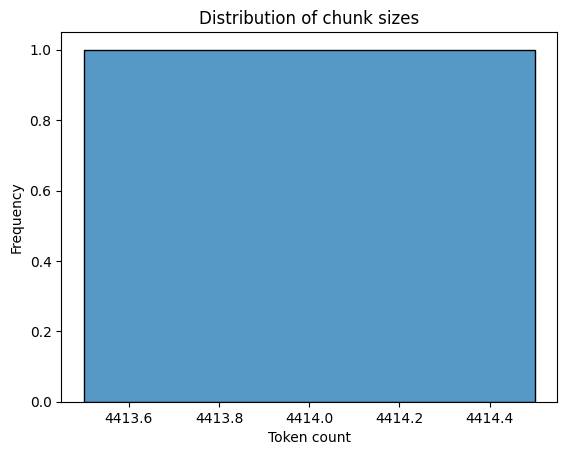

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(news["tokens"], kde=False)
plt.title('Distribution of chunk sizes')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.show()
     

In [217]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)
  

In [219]:
from typing import List
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document

def process_text(text: str) -> List[GraphDocument]:
    doc = Document(page_content=text)
    return llm_transformer.convert_to_graph_documents([doc])

In [221]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

MAX_WORKERS = 10
NUM_ARTICLES = 2000
graph_documents = []

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(process_text, f"{row['title']} {row['text']}")
        for i, row in news.head(NUM_ARTICLES).iterrows()
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        graph_document = future.result()
        graph_documents.extend(graph_document)

graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Processing documents: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


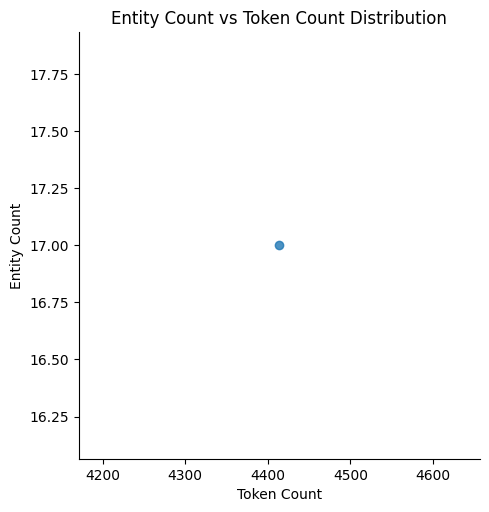

In [223]:
entity_dist = graph.query(
    """
MATCH (d:Document)
RETURN d.text AS text,
       count {(d)-[:MENTIONS]->()} AS entity_count
"""
)
entity_dist_df = pd.DataFrame.from_records(entity_dist)
entity_dist_df["token_count"] = [
    num_tokens_from_string(str(el)) for el in entity_dist_df["text"]
]
# Scatter plot with regression line
sns.lmplot(
    x="token_count", y="entity_count", data=entity_dist_df, line_kws={"color": "red"}
)
plt.title("Entity Count vs Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Entity Count")
plt.show()

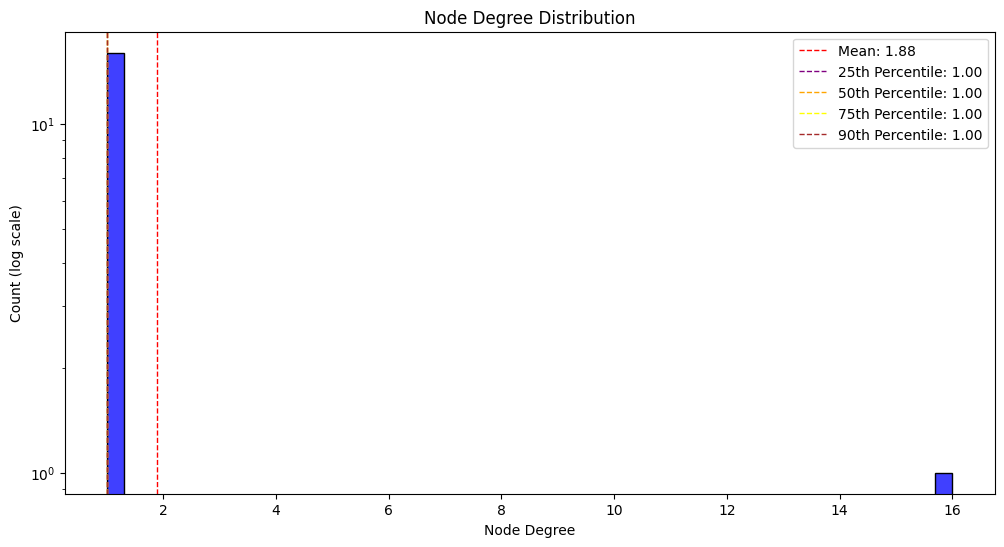

In [225]:
import numpy as np

degree_dist = graph.query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:!MENTIONS]-()} AS node_degree
"""
)
degree_dist_df = pd.DataFrame.from_records(degree_dist)

# Calculate mean and median
mean_degree = np.mean(degree_dist_df['node_degree'])
percentiles = np.percentile(degree_dist_df['node_degree'], [25, 50, 75, 90])
# Create a histogram with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df['node_degree'], bins=50, kde=False, color='blue')
# Use a logarithmic scale for the x-axis
plt.yscale('log')
# Adding labels and title
plt.xlabel('Node Degree')
plt.ylabel('Count (log scale)')
plt.title('Node Degree Distribution')
# Add mean, median, and percentile lines
plt.axvline(mean_degree, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_degree:.2f}')
plt.axvline(percentiles[0], color='purple', linestyle='dashed', linewidth=1, label=f'25th Percentile: {percentiles[0]:.2f}')
plt.axvline(percentiles[1], color='orange', linestyle='dashed', linewidth=1, label=f'50th Percentile: {percentiles[1]:.2f}')
plt.axvline(percentiles[2], color='yellow', linestyle='dashed', linewidth=1, label=f'75th Percentile: {percentiles[2]:.2f}')
plt.axvline(percentiles[3], color='brown', linestyle='dashed', linewidth=1, label=f'90th Percentile: {percentiles[3]:.2f}')
# Add legend
plt.legend()
# Show the plot
plt.show()
     

In [227]:
graph.query("""
MATCH (n:`__Entity__`)
RETURN "node" AS type,
       count(*) AS total_count,
       count(n.description) AS non_null_descriptions
UNION ALL
MATCH (n)-[r:!MENTIONS]->()
RETURN "relationship" AS type,
       count(*) AS total_count,
       count(r.description) AS non_null_descriptions
""")
     

[{'type': 'node', 'total_count': 17, 'non_null_descriptions': 1},
 {'type': 'relationship', 'total_count': 16, 'non_null_descriptions': 0}]

In [229]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

vector = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    node_label='__Entity__',
    text_node_properties=['id', 'description'],
    embedding_node_property='embedding'
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('db.create.setVectorProperty' has been replaced by 'db.create.setNodeVectorProperty')} {position: line: 1, column: 72, offset: 71} for query: "UNWIND $data AS row MATCH (n:`__Entity__`) WHERE elementId(n) = row.id CALL db.create.setVectorProperty(n, 'embedding', row.embedding) YIELD node RETURN count(*)"


In [231]:
from graphdatascience import GraphDataScience
# project graph

gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [233]:
G, result = gds.graph.project(
    "entities",                   #  Graph name
    "__Entity__",                 #  Node projection
    "*",                          #  Relationship projection
    nodeProperties=["embedding"]  #  Configuration parameters
)
  

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [235]:
similarity_threshold = 0.95

gds.knn.mutate(
  G,
  nodeProperties=['embedding'],
  mutateRelationshipType= 'SIMILAR',
  mutateProperty= 'score',
  similarityCutoff=similarity_threshold
)

ranIterations                                                             2
nodePairsConsidered                                                    2916
didConverge                                                            True
preProcessingMillis                                                       3
computeMillis                                                            31
mutateMillis                                                             55
postProcessingMillis                                                      0
nodesCompared                                                            17
relationshipsWritten                                                     18
similarityDistribution    {'min': 0.9500274658203125, 'p5': 0.9500274658...
configuration             {'mutateProperty': 'score', 'jobId': 'ca362e89...
Name: 0, dtype: object

In [237]:
gds.wcc.write(
    G,
    writeProperty="wcc",
    relationshipTypes=["SIMILAR"]
)

writeMillis                                                             13
nodePropertiesWritten                                                   17
componentCount                                                           9
componentDistribution    {'min': 1, 'p5': 1, 'max': 6, 'p999': 6, 'p99'...
postProcessingMillis                                                    12
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'writeProperty': 'wcc', 'jobId': '50bcda33-30...
Name: 0, dtype: object

In [239]:
word_edit_distance = 3
potential_duplicate_candidates = graph.query(
    """MATCH (e:`__Entity__`)
    WHERE size(e.id) > 4 // longer than 4 characters
    WITH e.wcc AS community, collect(e) AS nodes, count(*) AS count
    WHERE count > 1
    UNWIND nodes AS node
    // Add text distance
    WITH distinct
      [n IN nodes WHERE apoc.text.distance(toLower(node.id), toLower(n.id)) < $distance | n.id] AS intermediate_results
    WHERE size(intermediate_results) > 1
    WITH collect(intermediate_results) AS results
    // combine groups together if they share elements
    UNWIND range(0, size(results)-1, 1) as index
    WITH results, index, results[index] as result
    WITH apoc.coll.sort(reduce(acc = result, index2 IN range(0, size(results)-1, 1) |
            CASE WHEN index <> index2 AND
                size(apoc.coll.intersection(acc, results[index2])) > 0
                THEN apoc.coll.union(acc, results[index2])
                ELSE acc
            END
    )) as combinedResult
    WITH distinct(combinedResult) as combinedResult
    // extra filtering
    WITH collect(combinedResult) as allCombinedResults
    UNWIND range(0, size(allCombinedResults)-1, 1) as combinedResultIndex
    WITH allCombinedResults[combinedResultIndex] as combinedResult, combinedResultIndex, allCombinedResults
    WHERE NOT any(x IN range(0,size(allCombinedResults)-1,1)
        WHERE x <> combinedResultIndex
        AND apoc.coll.containsAll(allCombinedResults[x], combinedResult)
    )
    RETURN combinedResult
    """, params={'distance': word_edit_distance})
potential_duplicate_candidates[:5]

[]

In [241]:
system_prompt = """You are a data processing assistant. Your task is to identify duplicate entities in a list and decide which of them should be merged.
The entities might be slightly different in format or content, but essentially refer to the same thing. Use your analytical skills to determine duplicates.

Here are the rules for identifying duplicates:
1. Entities with minor typographical differences should be considered duplicates.
2. Entities with different formats but the same content should be considered duplicates.
3. Entities that refer to the same real-world object or concept, even if described differently, should be considered duplicates.
4. If it refers to different numbers, dates, or products, do not merge results
"""
user_template = """
Here is the list of entities to process:
{entities}

Please identify duplicates, merge them, and provide the merged list.
"""

In [243]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from retry import retry

class DuplicateEntities(BaseModel):
    entities: List[str] = Field(
        description="Entities that represent the same object or real-world entity and should be merged"
    )


class Disambiguate(BaseModel):
    merge_entities: Optional[List[DuplicateEntities]] = Field(
        description="Lists of entities that represent the same object or real-world entity and should be merged"
    )


extraction_llm = ChatOpenAI(model_name="gpt-4o").with_structured_output(
    Disambiguate
)

extraction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        (
            "human",
            user_template,
        ),
    ]
)
  

In [245]:
extraction_chain = extraction_prompt | extraction_llm

@retry(tries=3, delay=2)
def entity_resolution(entities: List[str]) -> Optional[List[str]]:
    return [
        el.entities
        for el in extraction_chain.invoke({"entities": entities}).merge_entities
    ]

In [247]:
entity_resolution(['Tomato can grow under tropical climatic ', 'Tomato can grow under tropical climatic '])

[['Tomato can grow under tropical climatic ',
  'Tomato can grow under tropical climatic ']]

In [249]:
entity_resolution({"entities": ['26-7-2020']})

[['26-7-2020']]

In [253]:
merged_entities = []
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submitting all tasks and creating a list of future objects
    futures = [
        executor.submit(entity_resolution, el['combinedResult'])
        for el in potential_duplicate_candidates
    ]

    for future in tqdm(
        as_completed(futures), total=len(futures), desc="Processing documents"
    ):
        to_merge = future.result()
        if to_merge:
            merged_entities.extend(to_merge)

Processing documents: 0it [00:00, ?it/s]


In [255]:
merged_entities[:10]

[]

In [257]:
graph.query("""
UNWIND $data AS candidates
CALL {
  WITH candidates
  MATCH (e:__Entity__) WHERE e.id IN candidates
  RETURN collect(e) AS nodes
}
CALL apoc.refactor.mergeNodes(nodes, {properties: {
    `.*`: 'discard'
}})
YIELD node
RETURN count(*)
""", params={"data": merged_entities})

[{'count(*)': 0}]

In [259]:
G.drop()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $failIfMissing)'


graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               17
relationshipCount                                                       34
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                              0.125
creationTime                           2024-07-25T19:13:00.080279409+00:00
modificationTime                       2024-07-25T19:13:04.793028115+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

In [269]:
G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    {
        "_ALL_": {
            "type": "*",
            "orientation": "UNDIRECTED",
            "properties": {"weight": {"property": "*", "aggregation": "COUNT"}},
        }
    },
)
   

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'communities' already exists.}

In [271]:
wcc = gds.wcc.stats(G)
print(f"Component count: {wcc['componentCount']}")
print(f"Component distribution: {wcc['componentDistribution']}")

Component count: 1
Component distribution: {'min': 17, 'p5': 17, 'max': 17, 'p999': 17, 'p99': 17, 'p1': 17, 'p10': 17, 'p90': 17, 'p50': 17, 'p25': 17, 'p75': 17, 'p95': 17, 'mean': 17.0}


In [273]:
gds.leiden.write(
    G,
    writeProperty="communities",
    includeIntermediateCommunities=True,
    relationshipWeightProperty="weight",
)


writeMillis                                                              7
nodePropertiesWritten                                                   17
ranLevels                                                                1
didConverge                                                           True
nodeCount                                                               17
communityCount                                                           1
communityDistribution    {'min': 17, 'p5': 17, 'max': 17, 'p999': 17, '...
modularity                                                             0.0
modularities                                                         [0.0]
postProcessingMillis                                                     2
preProcessingMillis                                                      0
computeMillis                                                           35
configuration            {'writeProperty': 'communities', 'theta': 0.01...
Name: 0, dtype: object

In [275]:
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;")

[]

In [277]:
graph.query("""
MATCH (e:`__Entity__`)
UNWIND range(0, size(e.communities) - 1 , 1) AS index
CALL {
  WITH e, index
  WITH e, index
  WHERE index = 0
  MERGE (c:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET c.level = index
  MERGE (e)-[:IN_COMMUNITY]->(c)
  RETURN count(*) AS count_0
}
CALL {
  WITH e, index
  WITH e, index
  WHERE index > 0
  MERGE (current:`__Community__` {id: toString(index) + '-' + toString(e.communities[index])})
  ON CREATE SET current.level = index
  MERGE (previous:`__Community__` {id: toString(index - 1) + '-' + toString(e.communities[index - 1])})
  ON CREATE SET previous.level = index - 1
  MERGE (previous)-[:IN_COMMUNITY]->(current)
  RETURN count(*) AS count_1
}
RETURN count(*)
""")

[{'count(*)': 17}]

In [279]:
graph.query("""
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(:__Entity__)<-[:MENTIONS]-(d:Document)
WITH c, count(distinct d) AS rank
SET c.community_rank = rank;
""")

[]

In [281]:
community_size = graph.query(
    """
MATCH (c:__Community__)<-[:IN_COMMUNITY*]-(e:__Entity__)
WITH c, count(distinct e) AS entities
RETURN split(c.id, '-')[0] AS level, entities
"""
)
community_size_df = pd.DataFrame.from_records(community_size)
percentiles_data = []
for level in community_size_df["level"].unique():
    subset = community_size_df[community_size_df["level"] == level]["entities"]
    num_communities = len(subset)
    percentiles = np.percentile(subset, [25, 50, 75, 90, 99])
    percentiles_data.append(
        [
            level,
            num_communities,
            percentiles[0],
            percentiles[1],
            percentiles[2],
            percentiles[3],
            percentiles[4],
            max(subset)
        ]
    )

# Create a DataFrame with the percentiles
percentiles_df = pd.DataFrame(
    percentiles_data,
    columns=[
        "Level",
        "Number of communities",
        "25th Percentile",
        "50th Percentile",
        "75th Percentile",
        "90th Percentile",
        "99th Percentile",
        "Max"
    ],
)
percentiles_df

,Level,Number of communities,25th Percentile,50th Percentile,75th Percentile,90th Percentile,99th Percentile,Max
0,0,1,17.0,17.0,17.0,17.0,17.0,17


In [283]:
community_info = graph.query("""
MATCH (c:`__Community__`)<-[:IN_COMMUNITY*]-(e:__Entity__)
WHERE c.level IN [0,1,4]
WITH c, collect(e ) AS nodes
WHERE size(nodes) > 1
CALL apoc.path.subgraphAll(nodes[0], {
	whitelistNodes:nodes
})
YIELD relationships
RETURN c.id AS communityId,
       [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) WHERE el <> '__Entity__'][0]}] AS nodes,
       [r in relationships | {start: startNode(r).id, type: type(r), end: endNode(r).id, description: r.description}] AS rels
""")
     

In [291]:
community_info[0]

{'communityId': '0-1',
 'nodes': [{'id': 'Tomato Farming',
   'description': 'Tomato farming involves all the activities geared towards the planting of tomato seeds to the last stage of harvesting the matured tomato fruits and marketing them.',
   'type': 'Concept'},
  {'id': 'Nigeria', 'description': None, 'type': 'Place'},
  {'id': 'Site Selection', 'description': None, 'type': 'Concept'},
  {'id': 'Climatic Conditions Requirement',
   'description': None,
   'type': 'Concept'},
  {'id': 'Finance Requirement', 'description': None, 'type': 'Concept'},
  {'id': 'Soil Requirement', 'description': None, 'type': 'Concept'},
  {'id': 'Land Preparation For Tomato Farming',
   'description': None,
   'type': 'Concept'},
  {'id': 'Variety Of Tomato To Plant', 'description': None, 'type': 'Concept'},
  {'id': 'Irrigation', 'description': None, 'type': 'Concept'},
  {'id': 'Nursery Management Of Tomato Seedlings',
   'description': None,
   'type': 'Concept'},
  {'id': 'Transplanting Of Seedlin

In [293]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

community_template = """Based on the provided nodes and relationships that belong to the same graph community,
generate a natural language summary of the provided information:
{community_info}

Summary:"""  # noqa: E501

community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", community_template),
    ]
)

community_chain = community_prompt | llm | StrOutputParser()

In [295]:
def prepare_string(data):
    nodes_str = "Nodes are:\n"
    for node in data['nodes']:
        node_id = node['id']
        node_type = node['type']
        if 'description' in node and node['description']:
            node_description = f", description: {node['description']}"
        else:
            node_description = ""
        nodes_str += f"id: {node_id}, type: {node_type}{node_description}\n"

    rels_str = "Relationships are:\n"
    for rel in data['rels']:
        start = rel['start']
        end = rel['end']
        rel_type = rel['type']
        if 'description' in rel and rel['description']:
            description = f", description: {rel['description']}"
        else:
            description = ""
        rels_str += f"({start})-[:{rel_type}]->({end}){description}\n"

    return nodes_str + "\n" + rels_str

def process_community(community):
    stringify_info = prepare_string(community)
    summary = community_chain.invoke({'community_info': stringify_info})
    return {"community": community['communityId'], "summary": summary}

In [299]:
print(prepare_string(community_info[0]))

Nodes are:
id: Tomato Farming, type: Concept, description: Tomato farming involves all the activities geared towards the planting of tomato seeds to the last stage of harvesting the matured tomato fruits and marketing them.
id: Nigeria, type: Place
id: Site Selection, type: Concept
id: Climatic Conditions Requirement, type: Concept
id: Finance Requirement, type: Concept
id: Soil Requirement, type: Concept
id: Land Preparation For Tomato Farming, type: Concept
id: Variety Of Tomato To Plant, type: Concept
id: Irrigation, type: Concept
id: Nursery Management Of Tomato Seedlings, type: Concept
id: Transplanting Of Seedlings, type: Concept
id: Application Of Fertilizers, type: Concept
id: Weed Control And Pruning In Tomato Farming, type: Concept
id: Pest Control In Tomato Farming, type: Concept
id: Disease Control, type: Concept
id: Harvest, type: Concept
id: Post-Harvest And Marketing, type: Concept

Relationships are:
(Tomato Farming)-[:LOCATION]->(Nigeria)
(Tomato Farming)-[:STEP]->(Sit

In [301]:
summaries = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_community, community): community for community in community_info}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing communities"):
        summaries.append(future.result())

Processing communities: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


In [305]:
# Store summaries
graph.query("""
UNWIND $data AS row
MERGE (c:__Community__ {id:row.community})
SET c.summary = row.summary
""", params={"data": summaries})

[]